In [87]:
"""
*Filename: SecondaryVertexDeepSetTrainer
*Description: This jupyter notebook is an extension of the ProjectorTrainer, it trains the same
*residual deep sets neural network architecture as the projector trainer with the additional
*features as well. In addition it adds the secondary vertex displacement of the b_jets as an
*additional target for the network to converge to.
Date: 16/02/2023
Author: Kaylen Smith Darnbrook
"""
# Import relevant modules
import os
import numpy as np
import seaborn as sns
import wandb
#from wandb.keras import WandbCallback
from keras import callbacks
import keras
import DeepSetNeuralNetArchitecture as DSNNA
from DeepSetNeuralNetArchitecture import LogNormal_Loss_Function
from DeepSetNeuralNetArchitecture import Mean_Squared_Error
from HffragDeepSetsProjectionMultivariate import DeepSetsProjection
from sklearn.feature_selection import mutual_info_regression
import keras.backend as k
import uproot
import awkward as ak
import sklearn as sk
from numpy.lib.recfunctions import structured_to_unstructured
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import pandas as pd
from hffrag import fixedbinning
from hffrag import binneddensity
from keras.utils.vis_utils import plot_model
from timeit import default_timer as timer
import matplotlib.pyplot as plt
%matplotlib inline

In [88]:
#Format the style and format of the matplotlib plots
plt.style.use("default")
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'
plt.rc('text',usetex = False)
plt.rc('font',family = 'Times New Roman')

In [89]:
# The data is being stored in a tree datastructure.
# We access the charm root using this command
tree = uproot.open("/storage/epp2/phswmv/data/hffrag/hffrag.root:CharmAnalysis")

In [90]:
# Initial parameters
MASKVAL = -999 # This value is introduced to ensure arrays are regular (Of the same size). They will be masked later by the network
MAXTRACKS = 32 # This value is the maximum number of tracks allowed per event
BATCHSIZE = 64 # This is the batch size of the mini batches used during training
EPOCHS = 1000  # This is the default number of epochs for which the neural network will train providing that early stopping does not occur
MAXEVENTS = 2e5 #This is the maximum number of events that will the program will accept
LR = 3e-4 #This is the default learning rate

In [91]:
# Select the features we wish to study
track_features = ["AnalysisTracks_pt", "AnalysisTracks_eta", "AnalysisTracks_phi", "AnalysisTracks_z0sinTheta",
                   "AnalysisTracks_d0sig", "AnalysisTracks_d0", "AnalysisTracks_d0sigPV", "AnalysisTracks_d0PV"]
jet_features = ["AnalysisAntiKt4TruthJets_pt", "AnalysisAntiKt4TruthJets_eta", "AnalysisAntiKt4TruthJets_phi", "AnalysisAntiKt4TruthJets_m","AnalysisAntiKt4TruthJets_ghostB_pdgId",
                "AnalysisAntiKt4TruthJets_ghostB_pt", "AnalysisAntiKt4TruthJets_ghostB_eta","AnalysisAntiKt4TruthJets_ghostB_phi", "AnalysisAntiKt4TruthJets_ghostB_m"]
Electrons_features = ["AnalysisElectrons_pt_NOSYS","AnalysisElectrons_eta", "AnalysisElectrons_phi", "AnalysisElectrons_z0sinTheta", 
                    "AnalysisElectrons_d0sig", "AnalysisElectrons_d0", "AnalysisElectrons_d0sigPV", "AnalysisElectrons_d0PV"]
Muon_Features = ["AnalysisMuons_pt_NOSYS", "AnalysisMuons_eta", "AnalysisMuons_phi","AnalysisMuons_z0sinTheta", 
                    "AnalysisMuons_d0sig", "AnalysisMuons_d0", "AnalysisMuons_d0sigPV", "AnalysisMuons_d0PV"]

In [92]:
# Read in the data from the root file
features = tree.arrays(jet_features+track_features + Electrons_features + Muon_Features, entry_stop=MAXEVENTS)

In [93]:
# Select the events of interest
events = features[ak.sum(
    features["AnalysisAntiKt4TruthJets_pt"] > 25000, axis=1) > 0]

In [94]:
# Displays the number of jets being trained on
jets = events[jet_features][:,0]
print("The number of jets to train on is: ", len(jets))
print("The number of track features is: ",len(track_features))

The number of jets to train on is:  199840
The number of track features is:  8


In [95]:
# Select tracks from the events
tracks = events[track_features]
electrons = events[Electrons_features]
muons = events[Muon_Features]

# Match the tracks to the jets
mask_tracks = DSNNA.Match_Tracks(jets, tracks)
mask_electrons = DSNNA.Match_Electrons(jets,electrons)
mask_muons = DSNNA.Match_Muons(jets,muons)
matchedtracks = tracks[mask_tracks]
matchedelectrons = electrons[mask_electrons]
matchedmuons = muons[mask_muons]

# Pad and Flatten the data
matchedtracks = DSNNA.flatten(matchedtracks, MAXTRACKS)
matchedelectrons = DSNNA.flatten(matchedelectrons, MAXTRACKS)
matchedmuons = DSNNA.flatten(matchedmuons, MAXTRACKS)

In [96]:
#Selects the b-jets with bhadrons with a transverse momentum over 5000 MeV
bjets = ak.sum(jets["AnalysisAntiKt4TruthJets_ghostB_pt"] > 5000, axis=1) > 0
jets = jets[bjets]

# Obtain the pt, eta and phi of each b hadron jet
bhads_pt = jets["AnalysisAntiKt4TruthJets_ghostB_pt"][:, 0].to_numpy()
bhads_eta = jets["AnalysisAntiKt4TruthJets_ghostB_eta"][:,0].to_numpy()
bhads_phi = jets["AnalysisAntiKt4TruthJets_ghostB_phi"][:,0].to_numpy()
bhads_m = jets["AnalysisAntiKt4TruthJets_ghostB_m"][:,0].to_numpy()
bhads_PGID = jets["AnalysisAntiKt4TruthJets_ghostB_pdgId"][:,0].to_numpy()

jets_pt = jets["AnalysisAntiKt4TruthJets_pt"].to_numpy()
jets_eta = jets["AnalysisAntiKt4TruthJets_eta"].to_numpy()
jets_phi = jets["AnalysisAntiKt4TruthJets_phi"].to_numpy()
jets_m = jets["AnalysisAntiKt4TruthJets_m"].to_numpy()
b_jets = np.stack([jets_pt,jets_eta,jets_phi, jets_m], axis = -1)

bhads = np.stack([bhads_pt,bhads_eta,bhads_phi, bhads_m],axis = -1) #Combine the momentum, eta and phi for each jet into one array

print("There are {} outputs".format(np.shape(bhads)[1])) # Display the number of target features the neural network will predict
matchedtracks = matchedtracks[bjets]
matchedelectrons = matchedelectrons[bjets]
matchedmuons = matchedmuons[bjets]
print("There are {} tracks inputs".format(np.shape(matchedtracks)[1])) # Display the number of target features the neural network will use in it's predictions
print("There are {} electrons inputs".format(np.shape(matchedelectrons)[1])) # Display the number of target features the neural network will use in it's predictions
print("There are {} muons inputs".format(np.shape(matchedmuons)[1])) # Display the number of target features the neural network will use in it's predictions

There are 4 outputs
There are 32 tracks inputs
There are 32 electrons inputs
There are 32 muons inputs


In [97]:
# Transform the jet and tracks to unstructed data.
jets = structured_to_unstructured(jets[jet_features[:-5]])
matchedtracks = structured_to_unstructured(matchedtracks)
matchedelectrons  = structured_to_unstructured(matchedelectrons)
matchedmuons = structured_to_unstructured(matchedmuons)

In [98]:
# Convert the coordinates of the b jets and tracks to cartesian coordinates
polartracks = matchedtracks.to_numpy()
polarelectrons = matchedelectrons.to_numpy()
polarmuons = matchedmuons.to_numpy()

Num_events = MAXTRACKS
tracks_pt = polartracks[:,:,0].reshape(-1,Num_events,1)
tracks_eta = polartracks[:,:,1].reshape(-1,Num_events,1)
tracks_phi = polartracks[:,:,2].reshape(-1,Num_events,1)

tracks_pep = np.concatenate([tracks_pt,tracks_eta,tracks_phi], axis = -1) 
print(tracks_pep.shape)

electrons_pt = polarelectrons[:,:,0].reshape(-1,Num_events,1)
electrons_eta = polarelectrons[:,:,1].reshape(-1,Num_events,1)
electrons_phi = polarelectrons[:,:,2].reshape(-1,Num_events,1)

electrons_pep = np.concatenate([electrons_pt,electrons_eta,electrons_phi], axis = -1) 
print(electrons_pep.shape)

muons_pt = polarmuons[:,:,0].reshape(-1,Num_events,1)
muons_eta = polarmuons[:,:,1].reshape(-1,Num_events,1)
muons_phi = polarmuons[:,:,2].reshape(-1,Num_events,1)

muons_pep = np.concatenate([muons_pt,muons_eta,muons_phi], axis = -1) 
print(muons_pep.shape)

jets_pt = b_jets[:,0].reshape(-1,1)
jets_eta = b_jets[:,1].reshape(-1,1)
jets_phi = b_jets[:,2].reshape(-1,1)

b_jets_pep = np.concatenate([jets_pt,jets_eta,jets_phi], axis = -1) 
print(b_jets_pep.shape)

tracks_p = DSNNA.pt_eta_phi_2_px_py_pz_tracks(matchedtracks.to_numpy())
electrons_p = DSNNA.pt_eta_phi_2_px_py_pz_tracks(matchedelectrons.to_numpy())
muons_p = DSNNA.pt_eta_phi_2_px_py_pz_tracks(matchedmuons.to_numpy())

bhads = DSNNA.pt_eta_phi_2_px_py_pz_jets(bhads)
b_jets_p = DSNNA.pt_eta_phi_2_px_py_pz_jets(b_jets)
b_jets_m = b_jets[:,-1].reshape(-1,1)

#Combine the momenta of the tracks with the rest of the track features to form the track dataset
tracks = np.concatenate([tracks_p,tracks_pep,matchedtracks[:,:,3:].to_numpy()],axis = 2)
electrons = np.concatenate([electrons_p, electrons_pep, matchedelectrons[:,:,3:].to_numpy()], axis = 2)
muons = np.concatenate([muons_p, muons_pep, matchedmuons[:,:,3:].to_numpy()], axis = 2)

print(np.shape(tracks), np.shape(electrons), np.shape(muons))
particles = np.concatenate([tracks,electrons,muons], axis = 1)
b_jets = np.concatenate([b_jets_p,b_jets_pep,b_jets_m] ,axis = 1)

(96659, 32, 3)
(96659, 32, 3)
(96659, 32, 3)
(96659, 3)


/home/physics/phujdj/DeepLearningParticlePhysics/DeepSetNeuralNetArchitecture.py:146: RuntimeWarning: overflow encountered in sinh
  pzs = np.where(mask1 | mask3, pts, pts * np.sinh(etas))


(96659, 32, 11) (96659, 32, 11) (96659, 32, 11)


In [99]:
np.shape(particles)

(96659, 96, 11)

In [100]:
#Mask out the MASKVALs used to pad the arrays
particles = np.ma.masked_values(particles,-999)

In [101]:
#Calculate the fraction of the momenta that
# the bhadrons represent of the b_jet momenta
bhads_fractions_px = bhads[:,0]/b_jets[:,0]
bhads_fractions_py = bhads[:,1]/b_jets[:,1]
bhads_fractions_pz = bhads[:,2]/b_jets[:,2]
print(bhads_fractions_px.shape)

(96659,)


In [102]:
# Calculate the magnitude of the b_jets momenta and 
# use it to calculate the projection of the bhadron momenta along the 
# b_jet momenta
b_jets_mag = np.linalg.norm(b_jets[:,:3], axis = 1)
bhads_fractions = np.stack([bhads_fractions_px,bhads_fractions_py, bhads_fractions_pz], axis = -1)
bhads_projection = ((bhads[:,:3]*b_jets[:,:3]).sum(axis = 1))/(b_jets_mag**2)
print(bhads_fractions.shape)

(96659, 3)


In [103]:
#Creates an approximate track momentum and 4 momentum for the network to use.
particles_Momentum = np.sqrt(particles[:, : ,0]**2 + particles[:,:,1]**2 + particles[:,:,2]**2)
particles_4_Momentum = np.stack([particles_Momentum, particles[:,:,0], particles[:,:,1], particles[:,:,2]], axis = -1)
print(particles_4_Momentum.shape)

/tmp/ipykernel_8371/4078472412.py:2: RuntimeWarning: invalid value encountered in sqrt
  particles_Momentum = np.sqrt(particles[:, : ,0]**2 + particles[:,:,1]**2 + particles[:,:,2]**2)


(96659, 96, 4)


In [104]:
#Creates a very approximate track mass for the network to use.
particles_Invariant_Mass = np.sqrt((np.sum(particles_4_Momentum, axis = 1) * np.sum(particles_4_Momentum, axis = 1)).sum(axis = -1))
print(particles_Invariant_Mass.shape)

(96659,)


In [105]:
#From the base features for the tracks and jet provided by the roots 
#file calculate the derived features needed for convergence.
#These features were inspired from reading on current particle physics literature
b_jets_mag = np.linalg.norm(b_jets[:,:3], axis = 1)
bhads_mag = np.linalg.norm(bhads[:,:3], axis = 1)
particles_Momentum = np.sum(np.linalg.norm(particles[:,:,:3], axis = 2))

bhads_fractions_px = bhads[:,0]/b_jets[:,0]
bhads_fractions_py = bhads[:,1]/b_jets[:,1]
bhads_fractions_pz = bhads[:,2]/b_jets[:,2]
bhads_fractions_pt = bhads_pt/b_jets_pep[:,0]
print(bhads_fractions_px.shape)

b_jets_energy = np.sqrt((b_jets_m[:,0]**2) + (b_jets_mag**2))
print(b_jets_energy.shape, b_jets_m.shape)

b_jets_energy_pt = np.sqrt((b_jets_m[:,0]**2) + (b_jets[:,4]**2))
b_jets_energy_pt.shape


b_jet_energy_mass_ratio = b_jets_energy/b_jets_m[:,0]
b_jet_energy_mass_ratio[np.isinf(b_jet_energy_mass_ratio)] = np.median(b_jet_energy_mass_ratio)


print(b_jet_energy_mass_ratio.shape)
bhads_energy = np.sqrt((bhads_m**2) + (bhads_mag**2))
bhads_energy.shape

bhads_energy_mass_ratio = bhads_energy/bhads_m

print(bhads_fractions[0])
print(bhads[0,0]/b_jets[0,0])
print(np.min(bhads_fractions),np.max(bhads_fractions))

print(bhads_fractions_px[0])
print(bhads[0,0]/b_jets[0,0])
print(np.min(bhads_fractions_px),np.max(bhads_fractions_px))

print("Hello")
sum_px_particles = np.sum(particles[:,:,0], axis = 1)
sum_py_particles = np.sum(particles[:,:,1], axis = 1)
sum_pz_particles = np.sum(particles[:,:,2], axis = 1)
sum_pt_particles = np.sum(particles[:,:,3], axis = 1)
print(sum_pt_particles.shape)

sum_px_particles_RSE = np.sqrt(np.sum(particles[:,:,0]**2, axis = 1))
sum_py_particles_RSE= np.sqrt(np.sum(particles[:,:,1]**2, axis = 1))
sum_pz_particles_RSE = np.sqrt(np.sum(particles[:,:,2]**2, axis = 1))
sum_pt_particles_RSE = np.sqrt(np.sum(particles[:,:,3]**2, axis = 1))
print(sum_pt_particles_RSE.shape)

RSM_scaled_px = sum_px_particles_RSE/sum_px_particles
RSM_scaled_py = sum_py_particles_RSE/sum_py_particles
RSM_scaled_pz = sum_pz_particles_RSE/sum_pz_particles
RSM_scaled_pt = sum_pt_particles_RSE/sum_pt_particles
print(RSM_scaled_pt.shape)

RMS_scaled_px = np.sqrt(np.sum(particles[:,:,0]**2, axis = 1)/MAXTRACKS)
RMS_scaled_py = np.sqrt(np.sum(particles[:,:,1]**2, axis = 1)/MAXTRACKS)
RMS_scaled_pz = np.sqrt(np.sum(particles[:,:,2]**2, axis = 1)/MAXTRACKS)
RMS_scaled_pt = np.sqrt(np.sum(particles[:,:,3]**2, axis = 1)/MAXTRACKS)
print(RMS_scaled_pt.shape)

Log_px_particles = np.log(abs(particles[:,:,0]/b_jets[:,np.newaxis,0]))
Log_py_particles = np.log(abs(particles[:,:,1]/b_jets[:,np.newaxis,1]))
Log_pz_particles = np.log(abs(particles[:,:,2]/b_jets[:,np.newaxis,2]))
Log_pt_particles = np.log(abs(particles[:,:,3]/b_jets[:,np.newaxis,3]))
Log_particles = np.stack([Log_px_particles, Log_py_particles, Log_pz_particles, Log_pt_particles], axis = -1)

Log_Sum_px = np.log(sum_px_particles/b_jets[:,0])
Log_Sum_py = np.log(sum_py_particles/b_jets[:,1])
Log_Sum_pz = np.log(sum_pz_particles/b_jets[:,2])
Log_Sum_pt = np.log(sum_pt_particles/b_jets[:,3])
Log_Momenta = np.log(abs(particles_Momentum/np.sum(b_jets[:,:3], axis = 1)))
print(Log_Sum_pt.shape)

particles_fractions_px = particles[:,:,0]/b_jets[:,np.newaxis,0]
particles_fractions_py = particles[:,:,1]/b_jets[:,np.newaxis,1]
particles_fractions_pz = particles[:,:,2]/b_jets[:,np.newaxis,2]
particles_fractions_pt = particles[:,:,3]/b_jets[:,np.newaxis,3]
print(particles_fractions_pt.shape)
particles_fractions = np.stack([particles_fractions_px,particles_fractions_py, particles_fractions_pz], axis = -1)
print(particles_fractions.shape)

print(particles_fractions.shape)
print(particles[0,0,0]/b_jets[0,0])
print(np.mean(particles_fractions),np.std(particles_fractions))

particles_projection = ((particles[:,:,:3]*b_jets[:,np.newaxis,:3]).sum(axis = 2)/(b_jets_mag[:,np.newaxis]**2))
print(particles_projection.shape)
particles_Momenta = np.stack([sum_px_particles, sum_py_particles, sum_pz_particles], axis = -1)
print(particles_Momenta.shape)
Sum_particles_projection = ((particles_Momenta*b_jets[:,:3]).sum(axis = 1))/(b_jets_mag**2)
print(Sum_particles_projection.shape)

b_jet_energy_ratio_px = sum_px_particles/b_jets_energy
b_jet_energy_ratio_py = sum_py_particles/b_jets_energy
b_jet_energy_ratio_pz = sum_pz_particles/b_jets_energy
b_jet_energy_ratio_pt = sum_pt_particles/b_jets_energy
print(b_jet_energy_ratio_pt.shape)

b_jet_energy_ratio_cart = b_jets_mag/b_jets_energy
b_jet_energy_ratio_pt = b_jets[:,4]/b_jets_energy
print(b_jet_energy_ratio_pt.shape)

b_jet_energy_ratio_total = np.sum(b_jets[:,4])/np.sum(b_jets_energy)  
b_jet_transverse_mass = np.sqrt(b_jets_energy**2 - b_jets[:,2]**2)
bhads_transverse_mass = np.sqrt(bhads_energy**2 - bhads[:,2]**2)
print(b_jet_transverse_mass[0])
print(b_jet_energy_ratio_total.shape)
print(b_jet_transverse_mass.shape)
print(np.full((len(b_jets)),b_jet_energy_ratio_total).shape)
bhads_projection = ((bhads[:,:3]*b_jets[:,:3]).sum(axis = 1))/(b_jets_mag**2)

print(np.mean(b_jets_energy),np.std(b_jets_energy))
b_jets = np.stack([b_jets[:,0], b_jets[:,1], b_jets[:,2],b_jets[:,3],b_jets[:,4], b_jets[:,5], b_jets[:,6], b_jets_mag, sum_px_particles, sum_py_particles, sum_pz_particles, sum_pt_particles, sum_px_particles_RSE, sum_py_particles_RSE, sum_pz_particles_RSE, sum_pt_particles_RSE, RSM_scaled_px, RSM_scaled_py, RSM_scaled_pz, RSM_scaled_pt, RMS_scaled_px, RMS_scaled_py, RMS_scaled_pz, RMS_scaled_pt, b_jet_transverse_mass, Log_Sum_px, Log_Sum_py, Log_Sum_pz, Log_Sum_pt, Log_Momenta, b_jets_energy, b_jet_energy_ratio_px, b_jet_energy_ratio_py, b_jet_energy_ratio_pz, b_jet_energy_ratio_cart, b_jet_energy_ratio_pt, b_jet_energy_mass_ratio, np.full((len(b_jets),),b_jet_energy_ratio_total)], axis = -1)
bhads_targets = np.stack([bhads[:,0]/1e6,bhads[:,1]/1e6, bhads[:,2]/1e6,bhads_pt/1e6, bhads_eta, bhads_phi, bhads_energy/1e6, bhads_fractions_pt, bhads_projection], axis = -1)

(96659,)
(96659,) (96659, 1)
(96659,)
[0.9923946  1.00824593 0.99120818]
0.9923945992521676
-34465.39587820514 618.1237235802715
0.9923945992521676
0.9923945992521676
-4195.466731248074 618.1237235802715
Hello


/tmp/ipykernel_8371/772223639.py:21: RuntimeWarning: divide by zero encountered in true_divide
  b_jet_energy_mass_ratio = b_jets_energy/b_jets_m[:,0]


(96659,)
(96659,)
(96659,)
(96659,)


/tmp/ipykernel_8371/772223639.py:70: RuntimeWarning: divide by zero encountered in log
  Log_Sum_px = np.log(sum_px_particles/b_jets[:,0])
/tmp/ipykernel_8371/772223639.py:70: RuntimeWarning: invalid value encountered in log
  Log_Sum_px = np.log(sum_px_particles/b_jets[:,0])
/tmp/ipykernel_8371/772223639.py:71: RuntimeWarning: divide by zero encountered in log
  Log_Sum_py = np.log(sum_py_particles/b_jets[:,1])
/tmp/ipykernel_8371/772223639.py:71: RuntimeWarning: invalid value encountered in log
  Log_Sum_py = np.log(sum_py_particles/b_jets[:,1])
/tmp/ipykernel_8371/772223639.py:72: RuntimeWarning: divide by zero encountered in log
  Log_Sum_pz = np.log(sum_pz_particles/b_jets[:,2])
/tmp/ipykernel_8371/772223639.py:72: RuntimeWarning: invalid value encountered in log
  Log_Sum_pz = np.log(sum_pz_particles/b_jets[:,2])
/tmp/ipykernel_8371/772223639.py:73: RuntimeWarning: divide by zero encountered in log
  Log_Sum_pt = np.log(sum_pt_particles/b_jets[:,3])


(96659,)
(96659, 96)
(96659, 96, 3)
(96659, 96, 3)
0.14894195156291137
-889.5405690026124 312.0555330470199
(96659, 96)
(96659, 3)
(96659,)
(96659,)
(96659,)
79564.74
()
(96659,)
(96659,)
215380.48 189104.06


In [ ]:
np.min(b_jets),np.max(b_jets)

(-23884111.203433707, 31619725.805484924)

In [ ]:
np.min(bhads_targets), np.max(bhads_targets)

(-4.542725086212158, 4.581223011016846)

In [106]:
"""
0 - Momentum Px Scaled
1 - Momentum Py Scaled
2 - Momentum Pz Scaled
3-  Momentum Pt Scaled
4-  Momentum Eta Scaled
5 - Momentum Phi Scaled
6 - Tranvserse Impact parameter sin component
7 - Longitudinal Impact parameter
8 - Longitudinal Impact parameter signficiance
9 - Longitudinal Impact Parameter w.r.t PV
10 - Longitudinal Impact Parameter wr.r.t PV
11 - Momentum Fraction Px Scaled
12 - Momentum Fraction Py Scaled
13 - Momentum Fraction Pz Scaled
14 - Momentum Fraction pt Scaled.
15 - Logarithm of px of the tracks / b_jet x momenta
16 - Logarithm of py of the tracks / b_jet y momenta
17 - Logarithm of pz of the tracks / b_jet z momenta
18 - Logarithm of sum pt of the tracks / b_jet t momenta
"""
#Combine the features into one array
particles_input = np.concatenate([particles, Log_particles], axis = -1)
print(particles_input.shape)

(96659, 96, 15)


In [107]:
"""
0 - Momentum Px Scaled
1 - Momentum Py Scaled
2 - Momentum Pz Scaled
3 - Momentum Pt Scaled
4 - Momentum eta Scaled
5 - Momentum Phi Scaled
6 - Sum px of the tracks
7 - Sum py of the tracks
8 - Sum pz of the tracks
9 - Sum pt of the tracks
10 - Sqrt of the Sum px of the tracks
11 - Sqrt of the Sum py of the tracks
12 - Sqrt of the Sum pz of the tracks
13 - Sqrt of the Sum pt of the tracks
14 - Sqrt of the Sum px of the tracks scaled by the sum px of the tracks
15 - Sqrt of the Sum py of the tracks scaled by the sum py of the tracks
16 - Sqrt of the Sum pz of the tracks scaled by the sum pz of the tracks
17 - Sqrt of the Sum pt of the tracks scaked by the sum pt of the tracks
18 - Root Mean Square of the px momenta of the tracks
19 - Root Mean Square of the py momenta of the tracks
20 - Root Mean Square of the pz momenta of the tracks
21 - Root Mean Square of the pt momenta of the tracks
22 - Tranvserse mass of the b-jets
23 - Logarithm of the  Sum px of the tracks divide by the b_jet x momenta
24 - Logarithm of the  Sum py of the tracks divide by the b_jet y momenta
25 - Logarithm of the  Sum pz of the tracks divide by the b_jet z momenta
26 - Logarithm of the total momenta of the tracks divided by the b_jet total momenta
27 - B_jet energy
28 - B_jet energy ratio px
29 - B_jet energy ratio py
30 - B_jet energy ratio pz
31 - B_jet energy ratio pt
32 - B_jet energy ratio cart
32 - B_jet energy ratio pt
33 - B_jet energy ratio total
"""
#Combine the features into an array
b_jets_input = np.concatenate([b_jets, particles_projection, Sum_particles_projection.reshape(-1,1)], axis = -1)
print(b_jets_input.shape)

(96659, 135)


In [108]:
from collections import Counter
counter = Counter(bhads_PGID)
print(counter)

Counter({511: 20748, -521: 20663, -511: 20551, 521: 20534, 531: 4693, -531: 4656, 5122: 1893, -5122: 1848, 5132: 278, 5232: 267, -5132: 261, -5232: 250, 5332: 6, -5332: 6, -541: 4, 555: 1})


In [109]:
from sklearn.preprocessing import OneHotEncoder
counter = np.array([])
bhadron_PGIDs = []
for PGID in bhads_PGID:
    if (PGID == 521 or PGID == -521):
        element = 0
    elif (PGID == 511 or PGID == -511):
        element = 1
    else:
        element = 2
    counter = np.append(counter, [element])
    bhadron_PGIDs.append([str(element)])
print(np.shape(bhadron_PGIDs))
counter = Counter(counter)
print(counter)
encoder = OneHotEncoder(sparse = False)
onehot = encoder.fit_transform(bhadron_PGIDs)
print(np.shape(onehot))

(96659, 1)
Counter({1.0: 41299, 0.0: 41197, 2.0: 14163})
(96659, 3)


In [110]:
Scaler_particles = StandardScaler()
Num_events,Num_tracks,Num_features = np.shape(particles_input)
Scaled_particles = np.reshape(particles_input, newshape=(-1,Num_features))
particles_scaled = Scaler_particles.fit_transform(Scaled_particles)
particles_input_scaled = np.reshape(particles_scaled, newshape= (Num_events,Num_tracks,Num_features))
print(np.shape(particles_input_scaled))

Scaler_jets = StandardScaler()
Num_events,Num_features = np.shape(b_jets_input)
b_jets_scaled = np.reshape(b_jets_input, newshape=(-1,Num_features))
b_jets_scaled = Scaler_jets.fit_transform(b_jets_scaled)
b_jets_input_scaled = np.reshape(b_jets_scaled, newshape= (Num_events,Num_features))
print(np.shape(b_jets_input_scaled))

(96659, 96, 15)
(96659, 135)


In [111]:
# Builds the deep neural network
track_layers = [64 for x in range(2)]
jet_layers = [100 for x in range(3)]
b_jets_layers = [64 for x in range(2)]

track_layers = [np.shape(particles_input_scaled)[2]]+track_layers
print(track_layers)
print(np.shape(onehot)[1])
#Initializers the optimizer used for training the network
optimizer = tf.keras.optimizers.Nadam(LR)

#Build a DeepSets Projection Neural Network
DeepSetProjector = DeepSetsProjection(track_layers=track_layers, b_jet_layers= b_jets_layers, jet_layers=jet_layers, n_targets=np.shape(bhads_targets)[1], n_targets_classification= np.shape(onehot)[1], regularizer_strength= 1e-4, n_features=np.shape(b_jets_input_scaled)[1], Dropout_rate=0.1)

[15, 64, 64]
3


In [112]:
from DeepSetNeuralNetArchitecture import LogNormal_Loss_Function
from HffragDeepSetsProjection import Multivariate_Gaussian_Negative_Likelihood_Loss_Curve
from HffragDeepSetsProjectionMultivariate import weighted_categorical_crossentropy
DeepSetProjector.compile(
 optimizer = optimizer,
 loss = {"MultivariateLoss": Multivariate_Gaussian_Negative_Likelihood_Loss_Curve, "MassOutput":tf.keras.losses.categorical_crossentropy},
 metrics = [Mean_Squared_Error]   
)

In [113]:
#Summarises the DeepSetsProjector Set Neural Network Architecture
DeepSetProjector.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, None, 15)]   0           []                               
                                                                                                  
 time_distributed_10 (TimeDistr  (None, None, 15)    240         ['input_7[0][0]']                
 ibuted)                                                                                          
                                                                                                  
 time_distributed_residual_unit  (None, None, 15)    510         ['time_distributed_10[1][0]']    
 s_3 (TimeDistributedResidualUn                                                                   
 its)                                                                                       

In [114]:
# Introduce early_stopping to prevent overfitting
early_stopping = callbacks.EarlyStopping(
    min_delta=0.00001,  # The minimum amount of change to count as an improvement
    patience=50,  # The number of epochs to wait before stopping
    restore_best_weights=True,  # Keep the best weights
)
# Prevent spikes in the validation and training loss due to the gradient descent kicking the network out of a local minima
reduce_learn_on_plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.80, patience=15, min_lr=1e-9)

# Save the weights of the model to allow reuse in future.
path = "/home/physics/phujdj/DeepLearningParticlePhysics/CheckPointsDeepNet/ResidualDeepSetsWeights&BiasesLeptons.ckpt"
checkpoint_dir = os.path.dirname(path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=path,
                                                 save_weights_only=True, verbose=0, save_freq = 25*BATCHSIZE)
#Timer
#cb = TimingCallback()

#Weight&Biases Callback:
#Wanda = WandbCallback(save_graph = True,save_weights_only = True, log_weights = True, log_gradients = True, log_evaluation = True, training_data = (X_train,y_train), validation_data = (X_valid,y_valid), log_batch_frequency = 5)

# Learning Scheduler:
exponential_decay_fn = DSNNA.expontial_decay(lr0 = LR,s = 100)
learning_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [115]:
history  = DeepSetProjector.fit(
    (particles_input_scaled,b_jets_input_scaled), y = {"MultivariateLoss":bhads_targets, "MassOutput":onehot},
    validation_split = 0.3,
    epochs = EPOCHS,
    batch_size = BATCHSIZE,
    callbacks = [early_stopping, cp_callback, reduce_learn_on_plateau],
    )

Epoch 1/1000
1058/1058 [==============================] - 30s 21ms/step - loss: 11.0296 - MultivariateLoss_loss: -4.8246 - MassOutput_loss: 1.0147 - MultivariateLoss_Mean_Squared_Error: 0.4252 - MassOutput_Mean_Squared_Error: 0.2060 - val_loss: 4.8801 - val_MultivariateLoss_loss: -9.1177 - val_MassOutput_loss: 1.0139 - val_MultivariateLoss_Mean_Squared_Error: 0.2968 - val_MassOutput_Mean_Squared_Error: 0.2057 - lr: 3.0000e-04
Epoch 2/1000
1058/1058 [==============================] - 21s 20ms/step - loss: 2.1847 - MultivariateLoss_loss: -10.7480 - MassOutput_loss: 1.0098 - MultivariateLoss_Mean_Squared_Error: 0.1500 - MassOutput_Mean_Squared_Error: 0.2051 - val_loss: -0.2789 - val_MultivariateLoss_loss: -12.3435 - val_MassOutput_loss: 1.0152 - val_MultivariateLoss_Mean_Squared_Error: 0.0426 - val_MassOutput_Mean_Squared_Error: 0.2059 - lr: 3.0000e-04
Epoch 3/1000
1058/1058 [==============================] - 21s 20ms/step - loss: -1.8751 - MultivariateLoss_loss: -13.3080 - MassOutput_los

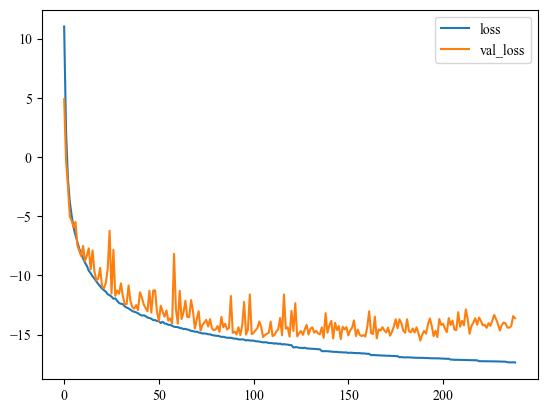

In [118]:
# Plot the loss and validation curves vs epoch
history_df = pd.DataFrame(history.history)
(history_df.loc[:, ["loss","val_loss"]]).plot()
history_df.to_csv('/home/physics/phujdj/DeepLearningParticlePhysics/historyResidualNeuralNetwork.csv')
DeepSetProjector.save_weights("/home/physics/phujdj/DeepLearningParticlePhysics/CheckPointsDeepNet/ResidualDeepSetsWeights&BiasesFixUpdated3.ckpt")

In [119]:
#Evaluate the entire performance of the model
loss = DeepSetProjector.evaluate((particles_input_scaled,b_jets_input_scaled),(bhads_targets, onehot),verbose = 2)
print("The Loaded DeepNet has loss: ", loss)

3021/3021 - 13s - loss: -1.6538e+01 - MultivariateLoss_loss: -1.8286e+01 - MassOutput_loss: 1.0070 - MultivariateLoss_Mean_Squared_Error: 0.0241 - MassOutput_Mean_Squared_Error: 0.2045 - 13s/epoch - 4ms/step
The Loaded DeepNet has loss:  [-16.53771209716797, -18.285667419433594, 1.0070375204086304, 0.024120915681123734, 0.20454014837741852]


In [120]:
predictions = DeepSetProjector.predict((particles_input_scaled, b_jets_input_scaled))

3021/3021 [==============================] - 12s 4ms/step


In [121]:
Predictions = predictions[0]
Predictions_Mass = predictions[1]

In [122]:
lister = []
index = 0
predictions_x = Predictions[:,:np.shape(bhads_targets)[1]]
predictions_X = predictions_x
predictions_x_uncertainty = Predictions[:,np.shape(bhads_targets)[1]:2*np.shape(bhads_targets)[1]]
Predictions_Uncertainty = predictions_x_uncertainty

In [171]:
np.save("/home/physics/phujdj/DeepLearningParticlePhysics/PredictionsMeans,npy", predictions_X)
np.save("/home/physics/phujdj/DeepLearningParticlePhysics/PredictionsUncertainties.npy", predictions_x_uncertainty)

In [123]:
Error_px_unscaled = (bhads_targets[:,0] - predictions_X[:,0])*1e6
Pull_bhads_px_unscaled = Error_px_unscaled/np.std(bhads_targets[:,0]*1e6)
Pull_px = Error_px_unscaled/(Predictions_Uncertainty[:,0]*1e6)

In [124]:
Error_py_unscaled = (bhads_targets[:,1] - predictions_X[:,1])*1e6
Pull_bhads_py_unscaled = Error_py_unscaled/np.std(bhads_targets[:,1]*1e6)
Pull_py = Error_py_unscaled/(Predictions_Uncertainty[:,1]*1e6)

In [125]:
Error_pz_unscaled = (bhads_targets[:,2] - predictions_X[:,2])*1e6
Pull_bhads_pz_unscaled = Error_pz_unscaled/np.std(bhads_targets[:,2]*1e6)
Pull_pz = Error_pz_unscaled/(Predictions_Uncertainty[:,2]*1e6)

In [126]:
Error_pt_unscaled = (bhads_targets[:,3] - predictions_X[:,3])*1e6
Pull_bhads_pt_unscaled = Error_pt_unscaled/np.std(bhads_targets[:,3]*1e6)
Pull_pt = Error_pt_unscaled/(Predictions_Uncertainty[:,3]*1e6)

In [127]:
Error_eta_unscaled = bhads_targets[:,4] - predictions_X[:,4]
Pull_bhads_eta_unscaled = Error_eta_unscaled/np.std(bhads_targets[:,4])
Pull_eta = Error_eta_unscaled/Predictions_Uncertainty[:,4]

In [128]:
Error_phi_unscaled = bhads_targets[:,5] - predictions_X[:,5]
Pull_bhads_pt_unscaled = Error_pt_unscaled/np.std(bhads_targets[:,5])
Pull_phi = Error_phi_unscaled/Predictions_Uncertainty[:,5]

In [129]:
Error_energy_unscaled = (bhads_targets[:,6] - predictions_X[:,6])*1e6
Pull_energy_unscaled = Error_energy_unscaled/np.std(bhads_targets[:,6]*1e6)
Pull_energy = Error_energy_unscaled/(Predictions_Uncertainty[:,6]*1e6)

In [130]:
Error_ptfraction_unscaled = bhads_targets[:,7] - predictions_X[:,7]
Pull_ptfraction_unscaled = Error_ptfraction_unscaled/np.std(bhads_targets[:,7])
Pull_ptfraction = Error_ptfraction_unscaled/Predictions_Uncertainty[:,7]

In [54]:
Error_projection_unscaled = bhads_targets[:,8] - predictions_X[:,8]
Pull_bhads_projection_unscaled = Error_projection_unscaled/np.std(bhads_targets[:,8])
Pull_projection = Error_projection_unscaled/Predictions_Uncertainty[:,8]

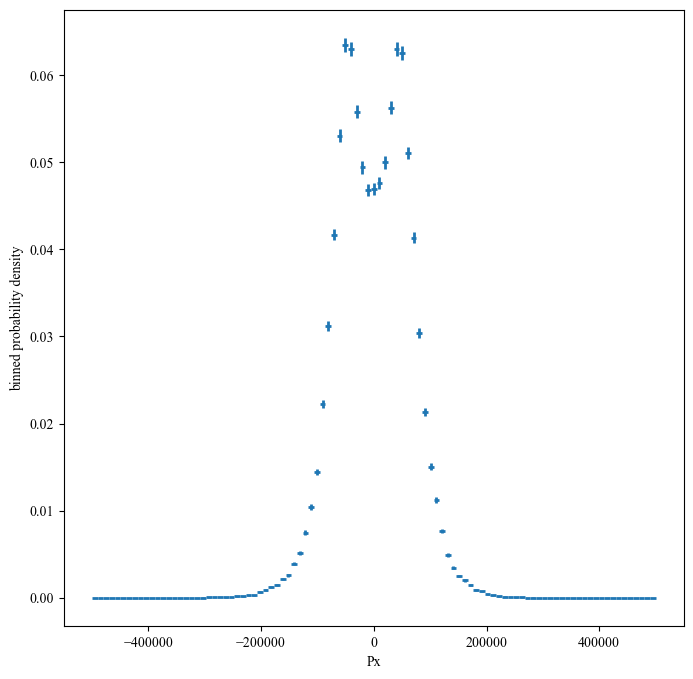

In [131]:
binneddensity(predictions_X[:,0]*1e6,fixedbinning(-5e5,5e5,100), xlabel = "Px")

471.3371863378137
15569.606574569645


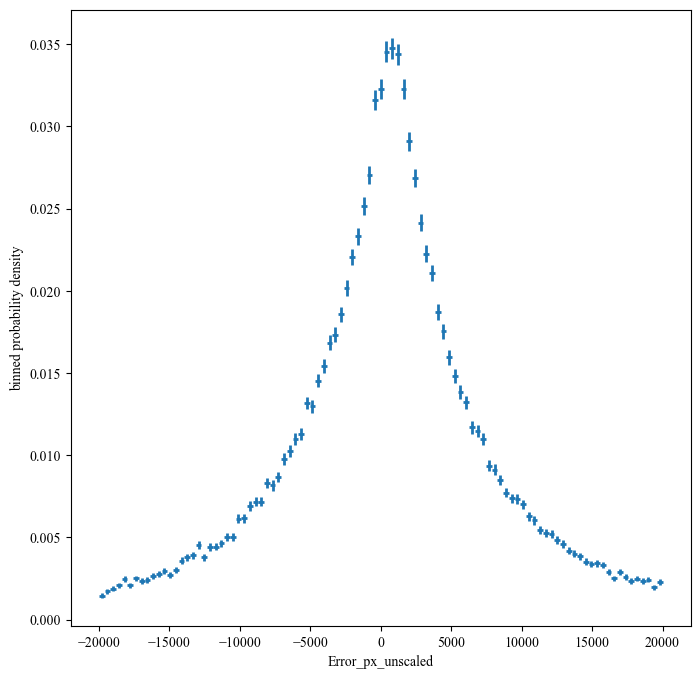

In [132]:
print(np.mean(Error_px_unscaled))
print(np.std(Error_px_unscaled))
binneddensity(Error_px_unscaled, fixedbinning(-20000,20000,100),xlabel = "Error_px_unscaled")

0.06309170850983394
0.8907582602093246


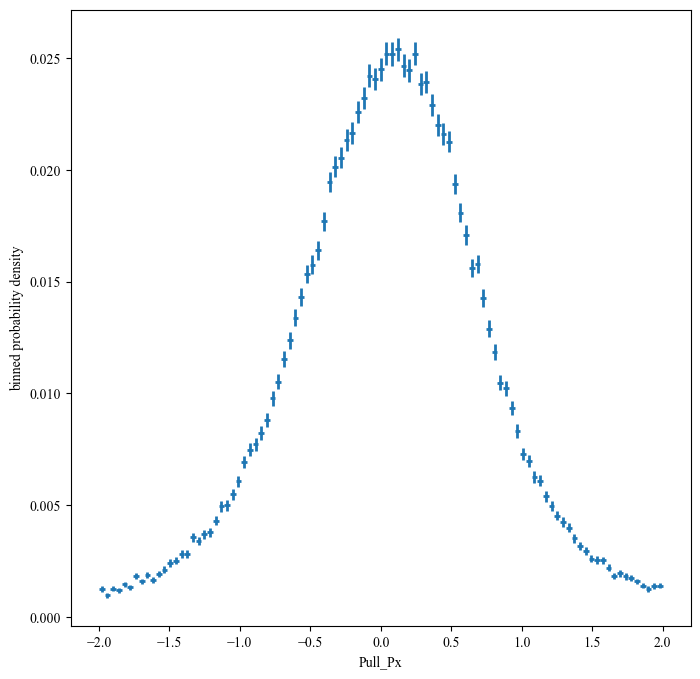

In [133]:
print(np.mean(Pull_px))
print(np.std(Pull_px))
binneddensity(Pull_px, fixedbinning(-2,2,100),xlabel = "Pull_Px")

722.4954915763154
15409.958651920837


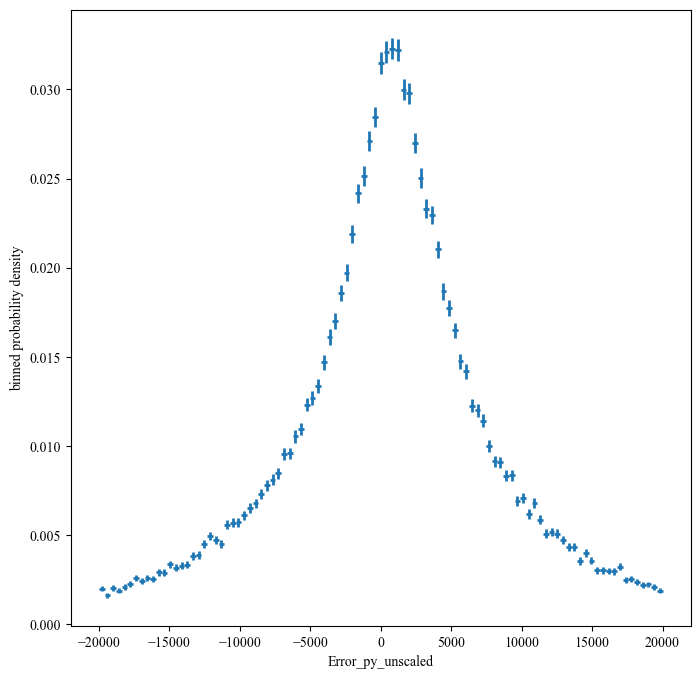

In [134]:
print(np.mean(Error_py_unscaled))
print(np.std(Error_py_unscaled))
binneddensity(Error_py_unscaled, fixedbinning(-20000,20000,100),xlabel = "Error_py_unscaled")

0.1030308331788892
0.9256124779506691


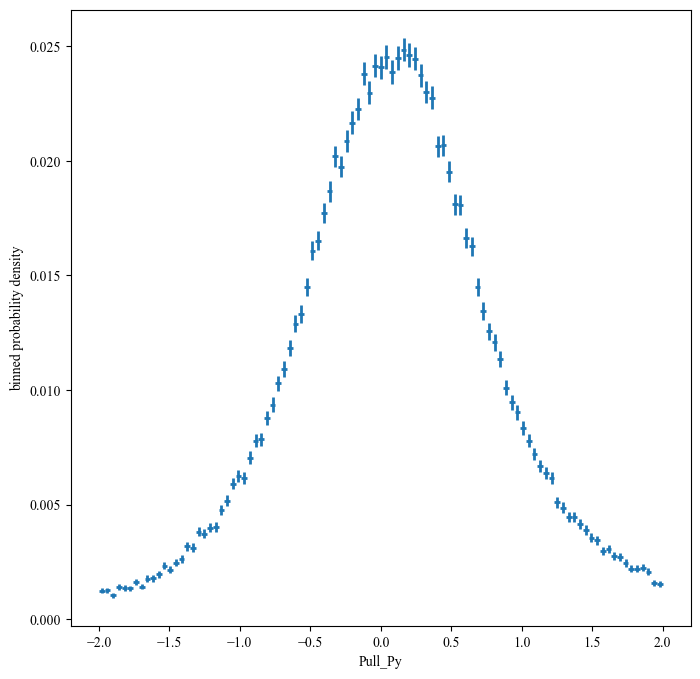

In [135]:
print(np.mean(Pull_py))
print(np.std(Pull_py))
binneddensity(Pull_py, fixedbinning(-2,2,100),xlabel = "Pull_Py")

-199.23402616601516
46793.52518826719


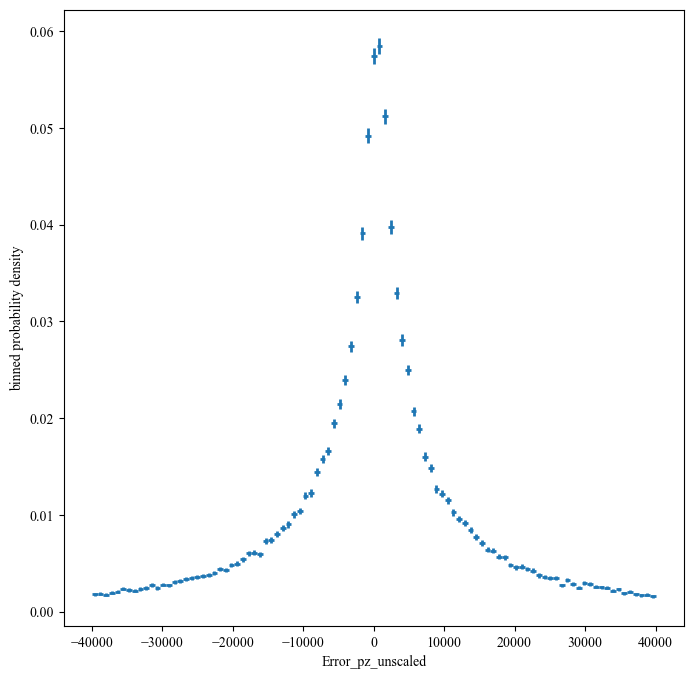

In [136]:
print(np.mean(Error_pz_unscaled))
print(np.std(Error_pz_unscaled))
binneddensity(Error_pz_unscaled, fixedbinning(-40000,40000,100),xlabel = "Error_pz_unscaled")

0.024189539957734988
0.9270644353449705


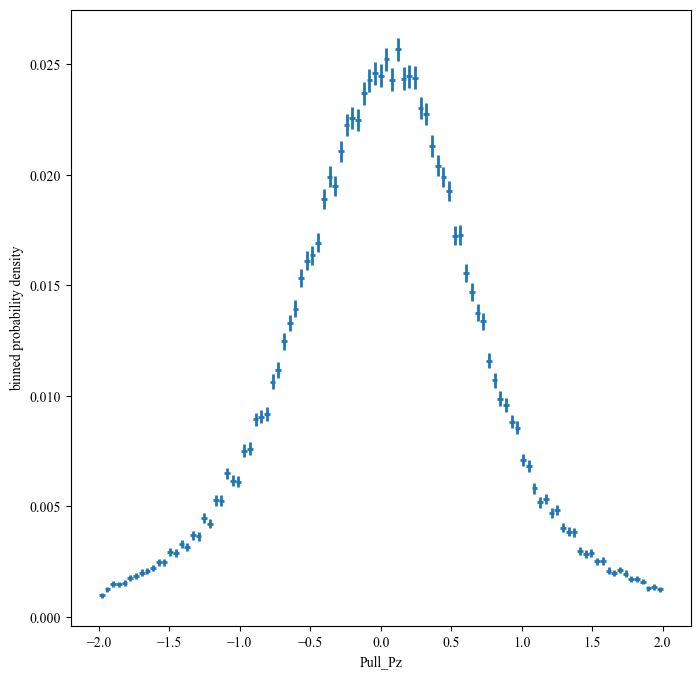

In [137]:
print(np.mean(Pull_pz))
print(np.std(Pull_pz))
binneddensity(Pull_pz, fixedbinning(-2,2,100),xlabel = "Pull_Pz")

-0.004033344393799809
0.1786409955174633


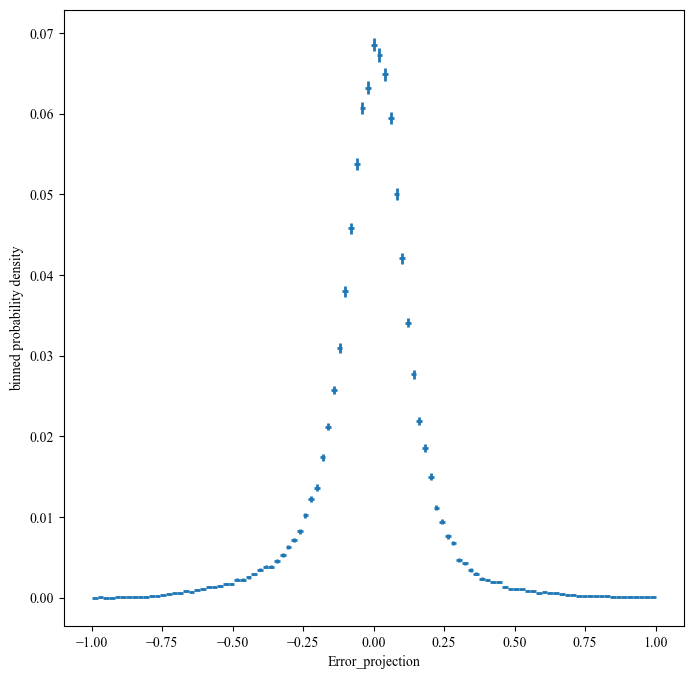

In [138]:
print(np.mean(Error_projection_unscaled))
print(np.std(Error_projection_unscaled))
binneddensity(Error_projection_unscaled, fixedbinning(-1,1,100),xlabel = "Error_projection")

-0.023737532043809077
1.0000847469590521


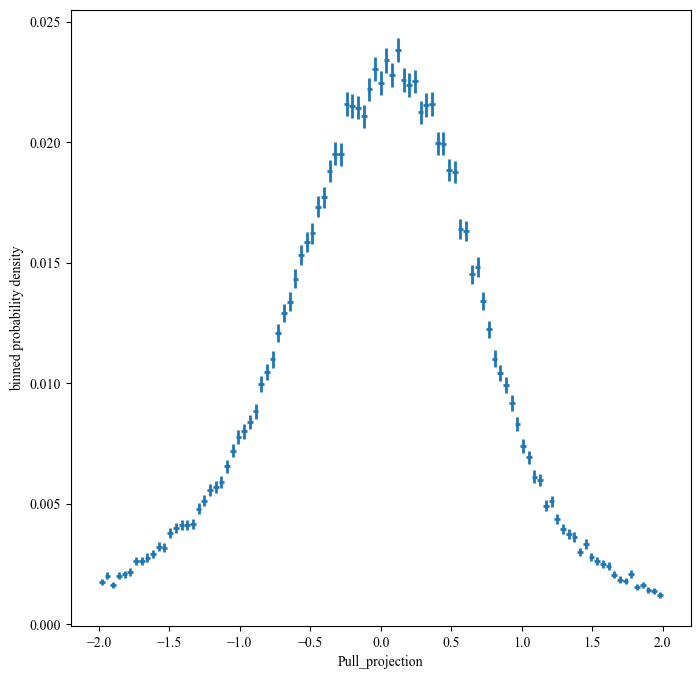

In [139]:
print(np.mean(Pull_projection))
print(np.std(Pull_projection))
binneddensity(Pull_projection, fixedbinning(-2,2,100),xlabel = "Pull_projection")

0.005372567128478266
0.1756165498059392


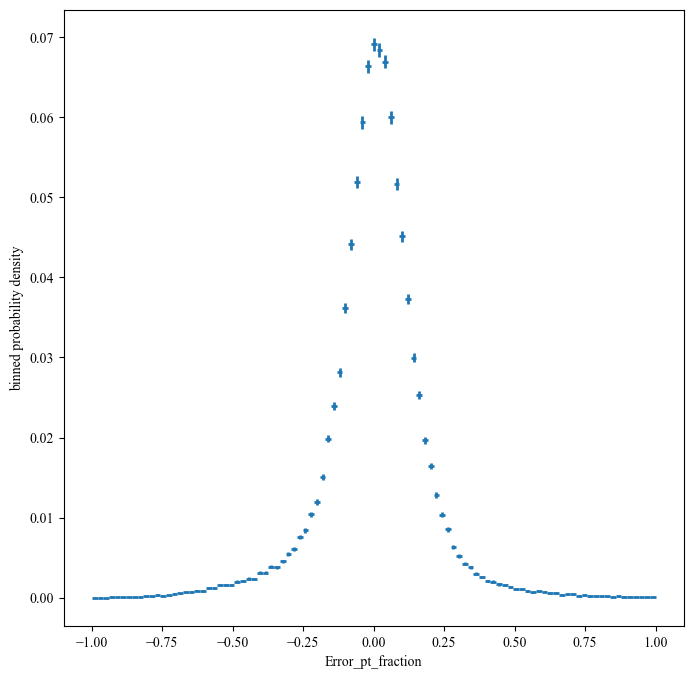

In [140]:
print(np.mean(Error_ptfraction_unscaled))
print(np.std(Error_ptfraction_unscaled))
binneddensity(Error_ptfraction_unscaled, fixedbinning(-1,1,100),xlabel = "Error_pt_fraction")

0.0217857633452789
0.7121252284232029


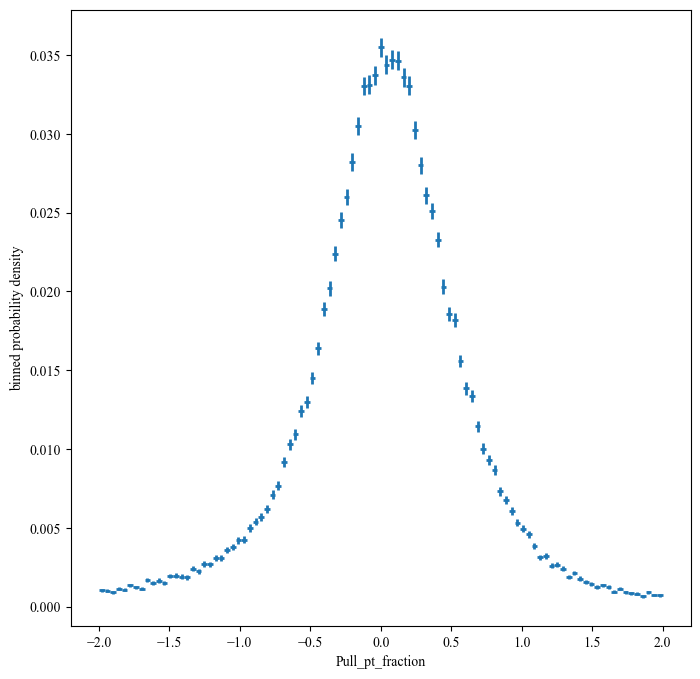

In [141]:
print(np.mean(Pull_ptfraction_unscaled))
print(np.std(Pull_ptfraction_unscaled))
binneddensity(Pull_ptfraction_unscaled, fixedbinning(-2,2,100),xlabel = "Pull_pt_fraction")

691.986033743184
51015.88682106005


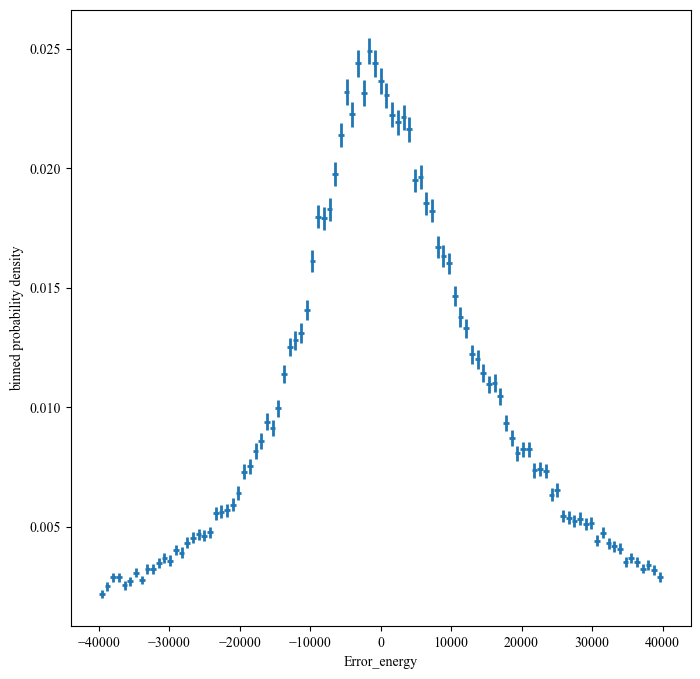

In [142]:
print(np.mean(Error_energy_unscaled))
print(np.std(Error_energy_unscaled))
binneddensity(Error_energy_unscaled, fixedbinning(-40000,40000,100),xlabel = "Error_energy")

0.004648929876892387
0.34273709131911045


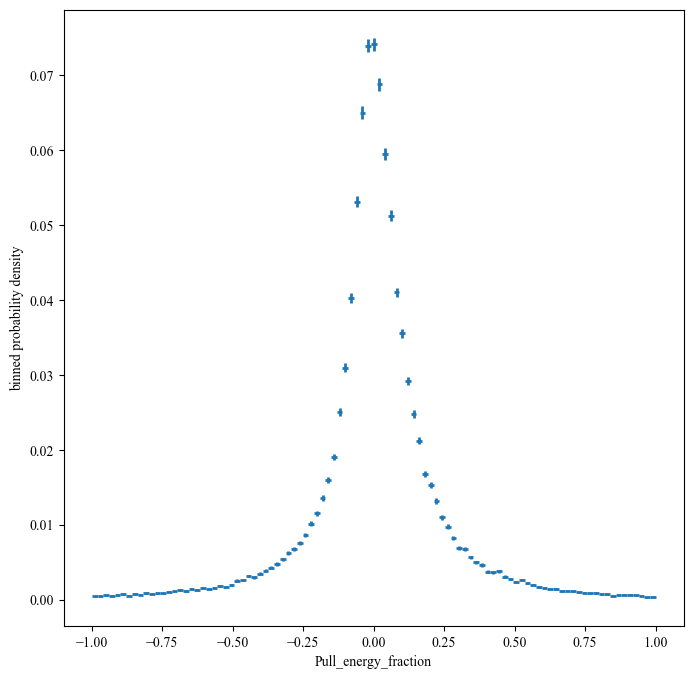

In [143]:
print(np.mean(Pull_energy_unscaled))
print(np.std(Pull_energy_unscaled))
binneddensity(Pull_energy_unscaled, fixedbinning(-1,1,100),xlabel = "Pull_energy_fraction")

-163.8661835434275
21468.474015760097


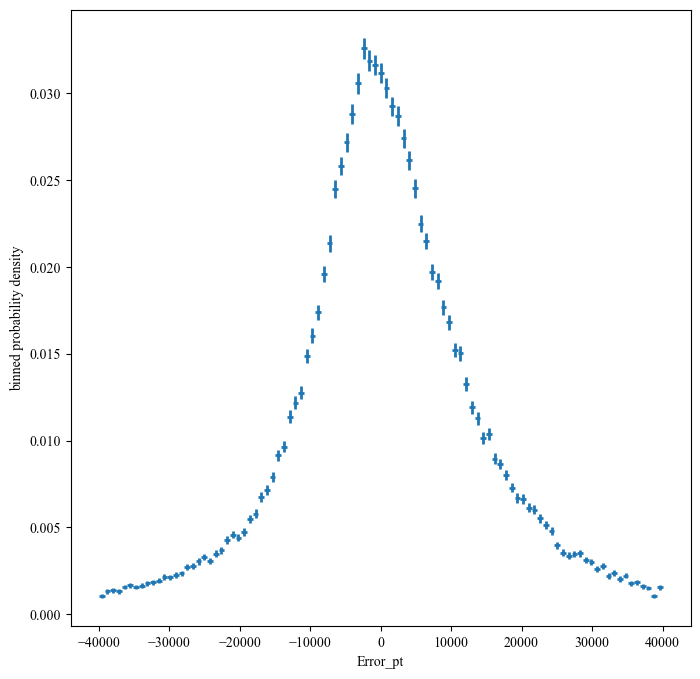

In [144]:
print(np.mean(Error_pt_unscaled))
print(np.std(Error_pt_unscaled))
binneddensity(Error_pt_unscaled, fixedbinning(-40000,40000,100),xlabel = "Error_pt")

-0.0217477094365554
0.9174574323177871


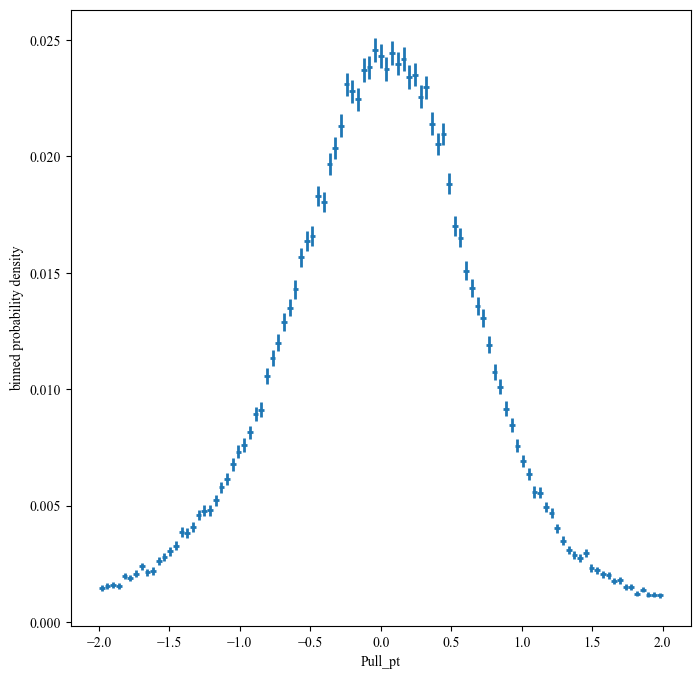

In [145]:
print(np.mean(Pull_pt))
print(np.std(Pull_pt))
binneddensity(Pull_pt, fixedbinning(-2,2,100),xlabel = "Pull_pt")

-0.0020118929958506697
0.05824323520033832


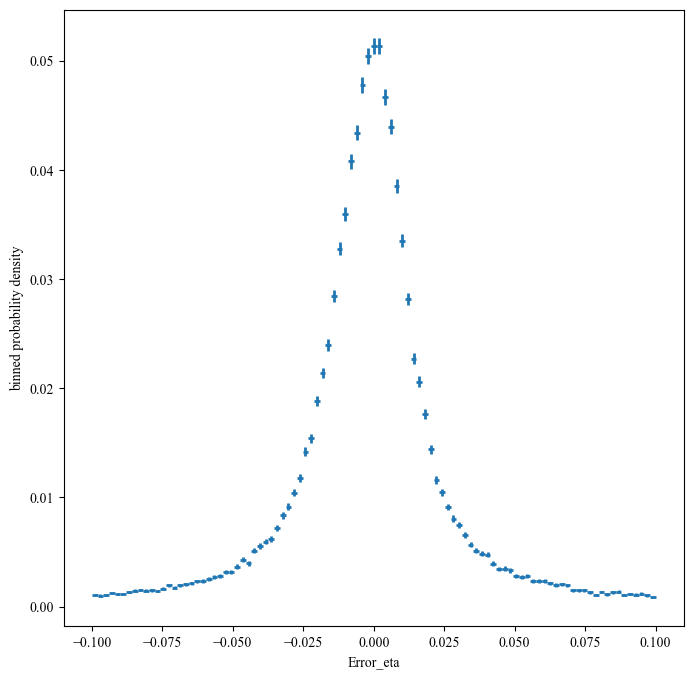

In [146]:
print(np.mean(Error_eta_unscaled))
print(np.std(Error_eta_unscaled))
binneddensity(Error_eta_unscaled, fixedbinning(-0.1,0.1,100),xlabel = "Error_eta")

-0.033435420996522275
0.9763992406007093


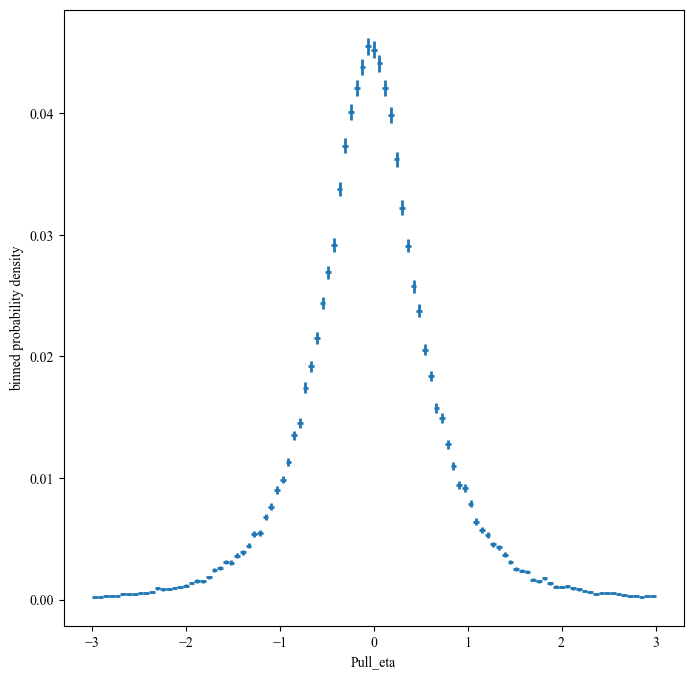

In [147]:
print(np.mean(Pull_eta))
print(np.std(Pull_eta))
binneddensity(Pull_eta, fixedbinning(-3,3,100),xlabel = "Pull_eta")

0.0019920078738514917
0.38281589478544753


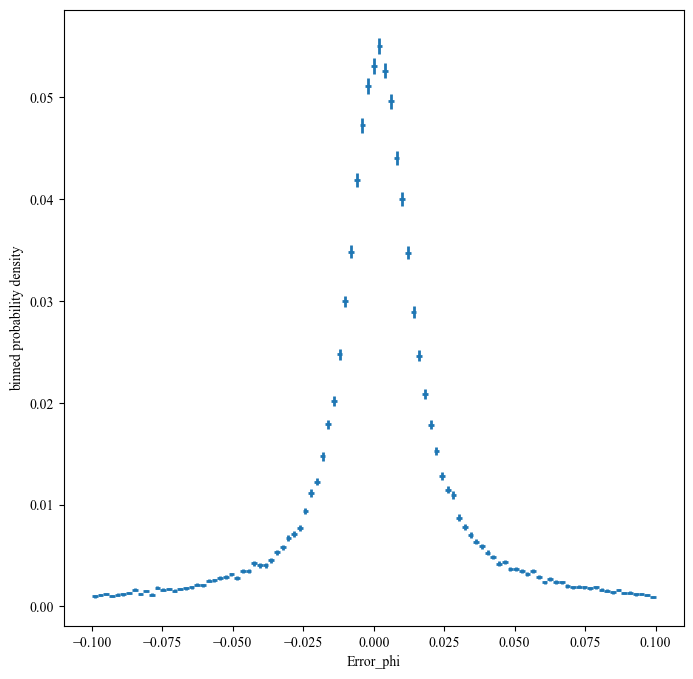

In [148]:
print(np.mean(Error_phi_unscaled))
print(np.std(Error_phi_unscaled))
binneddensity(Error_phi_unscaled, fixedbinning(-0.1,0.1,100),xlabel = "Error_phi")

0.07441796444238025
1.1084476740529365


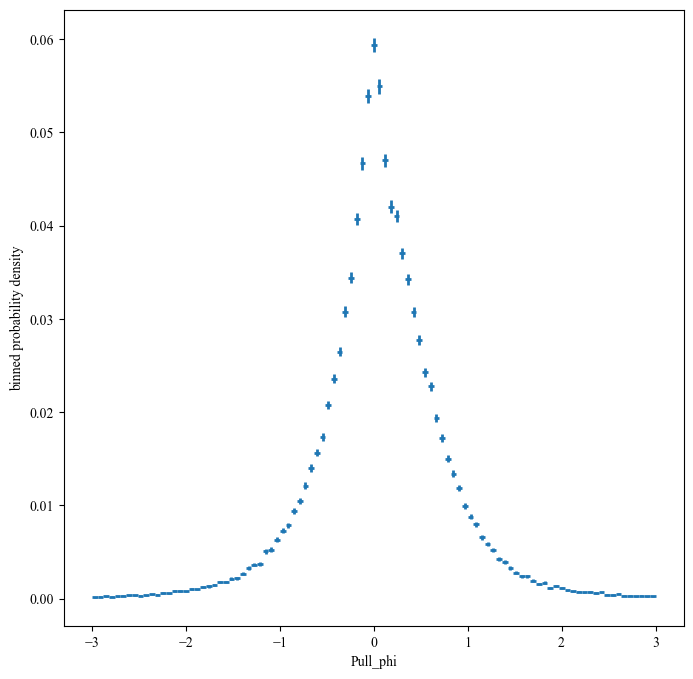

In [149]:
print(np.mean(Pull_phi))
print(np.std(Pull_phi))
binneddensity(Pull_phi, fixedbinning(-3,3,100),xlabel = "Pull_phi")

/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'The predicted X momenta of b hadron jets')

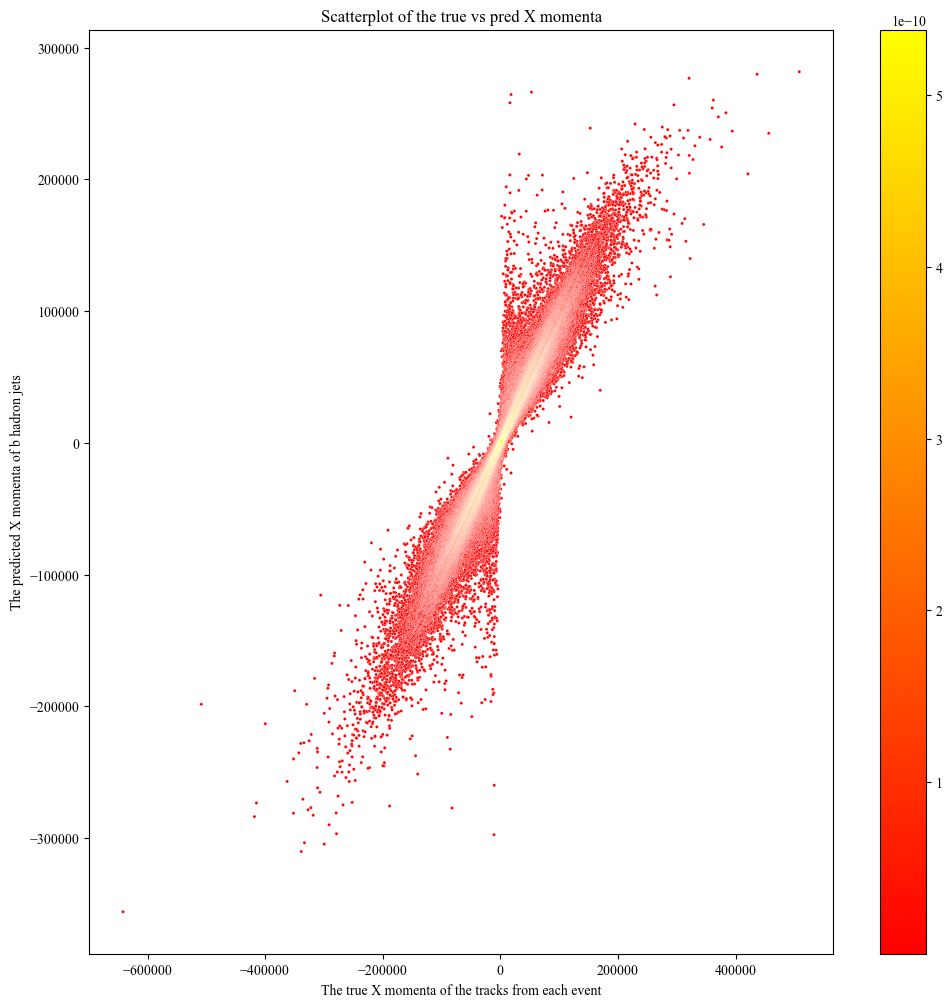

In [150]:
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
fig, ax = plt.subplots(figsize = (12,12))
x = bhads_targets[:,0]*1e6
y = predictions_X[:,0]*1e6
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x,
    y,
    c = z,
    s = 5,
    cmap = "autumn",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "autumn", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_title("Scatterplot of the true vs pred X momenta")
ax.set_xlabel("The true X momenta of the tracks from each event")
ax.set_ylabel("The predicted X momenta of b hadron jets")

/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'The predicted Y momenta of b hadron jets')

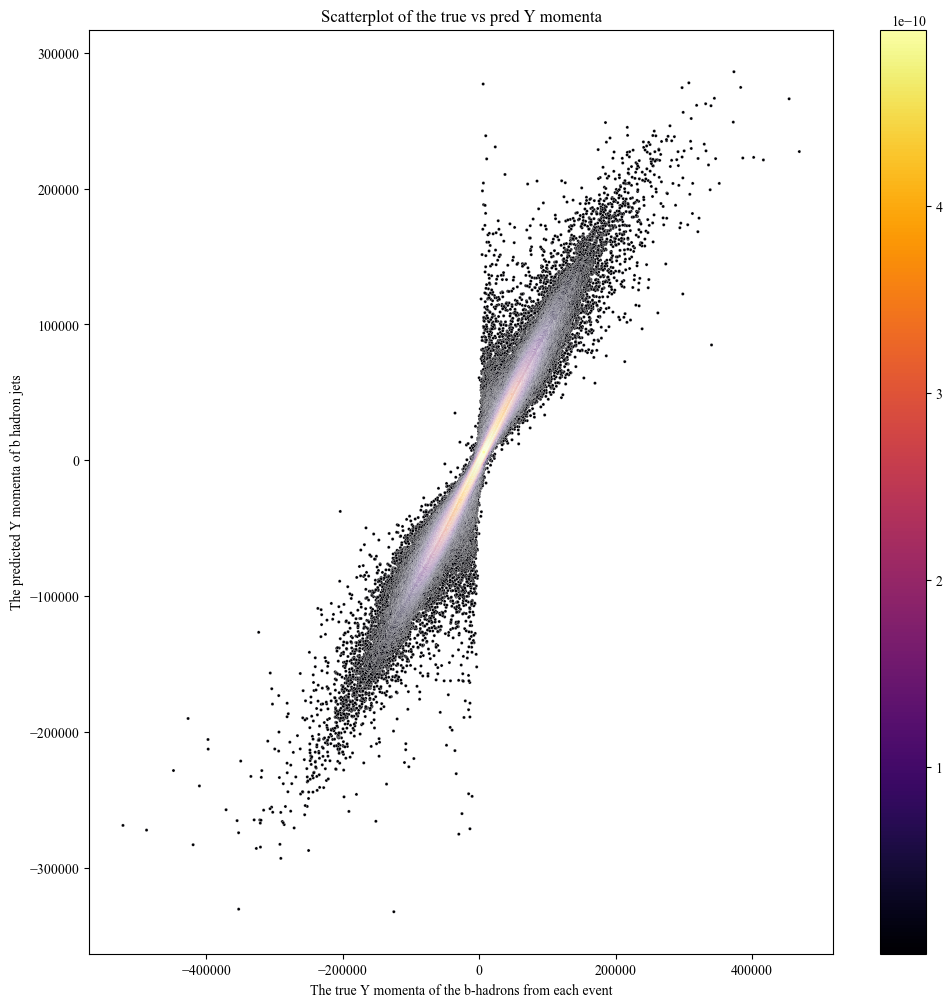

In [151]:
import matplotlib as mpl
from scipy.stats import gaussian_kde
fig, ax = plt.subplots(figsize = (12,12))
x = bhads_targets[:,1]*1e6
y = predictions_X[:,1]*1e6
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x,
    y,
    c = z,
    s = 5,
    cmap = "inferno",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "inferno", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_title("Scatterplot of the true vs pred Y momenta")
ax.set_xlabel("The true Y momenta of the b-hadrons from each event")
ax.set_ylabel("The predicted Y momenta of b hadron jets")

/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'The predicted Z momenta of b hadron jets')

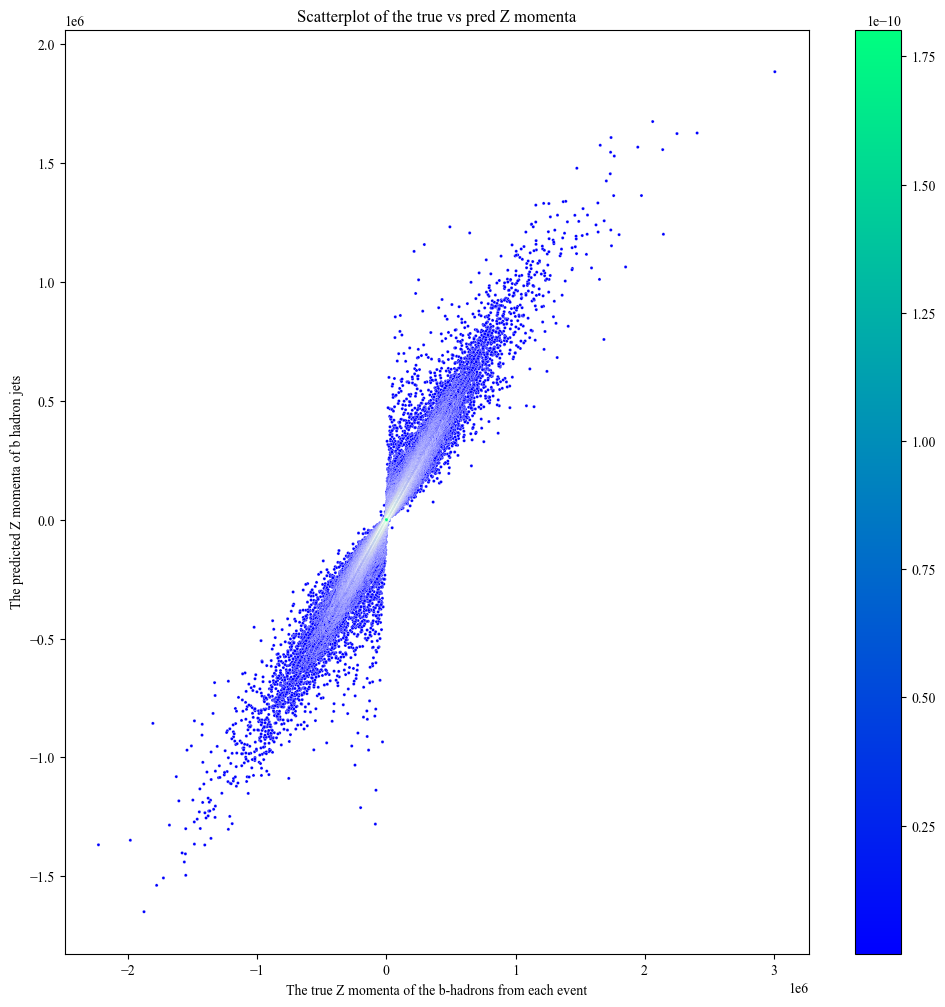

In [152]:
import matplotlib as mpl
from scipy.stats import gaussian_kde
fig, ax = plt.subplots(figsize = (12,12))
x = bhads_targets[:,2]*1e6
y = predictions_X[:,2]*1e6
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x,
    y,
    c = z,
    s = 5,
    cmap = "winter",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "winter", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_title("Scatterplot of the true vs pred Z momenta")
ax.set_xlabel("The true Z momenta of the b-hadrons from each event")
ax.set_ylabel("The predicted Z momenta of b hadron jets")

/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'The predicted transverse momenta of b hadron jets')

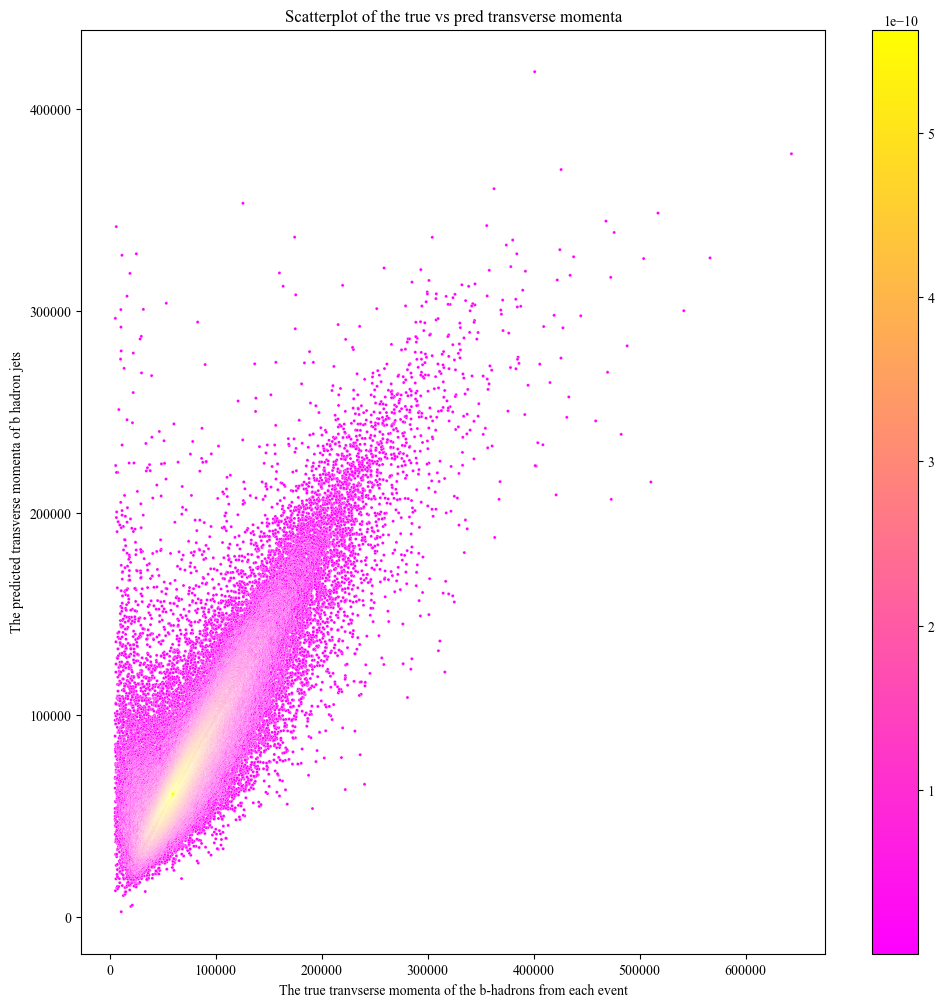

In [153]:
import matplotlib as mpl
from scipy.stats import gaussian_kde
fig, ax = plt.subplots(figsize = (12,12))
x = bhads_targets[:,3]*1e6
y = predictions_X[:,3]*1e6
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x,
    y,
    c = z,
    s = 5,
    cmap = "spring",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "spring", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_title("Scatterplot of the true vs pred transverse momenta")
ax.set_xlabel("The true tranvserse momenta of the b-hadrons from each event")
ax.set_ylabel("The predicted transverse momenta of b hadron jets")

/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'The predicted pseudorapidity of b hadron jets')

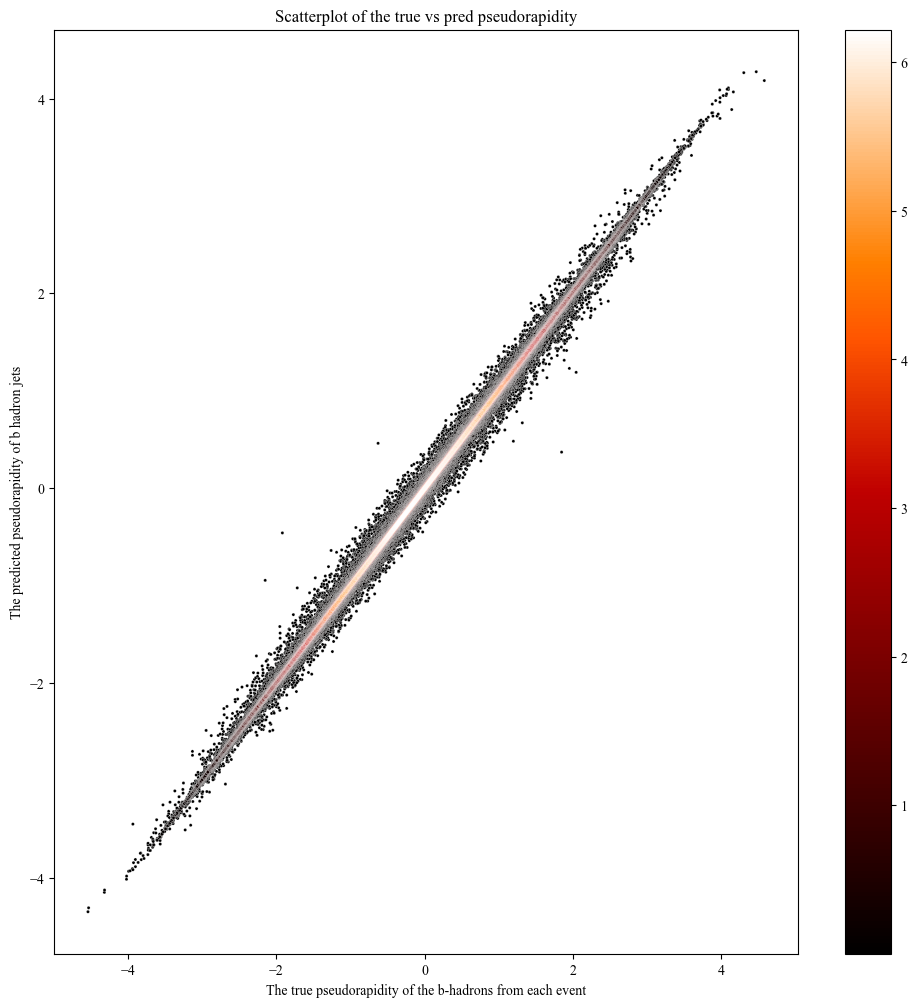

In [154]:
import matplotlib as mpl
from scipy.stats import gaussian_kde
fig, ax = plt.subplots(figsize = (12,12))
x = bhads_targets[:,4]
y = predictions_X[:,4]
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x,
    y,
    c = z,
    s = 5,
    cmap = "gist_heat",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "gist_heat", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_title("Scatterplot of the true vs pred pseudorapidity")
ax.set_xlabel("The true pseudorapidity of the b-hadrons from each event")
ax.set_ylabel("The predicted pseudorapidity of b hadron jets")

/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'The predicted phi of b hadron jets')

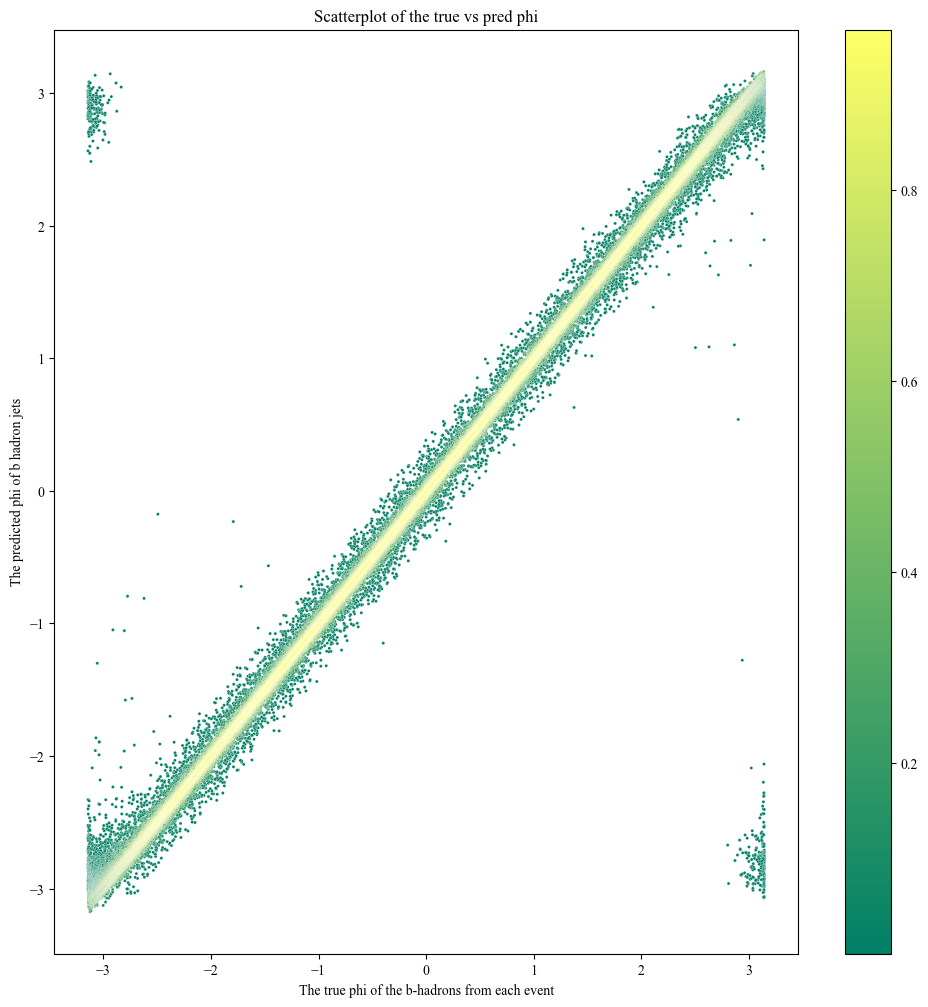

In [155]:
import matplotlib as mpl
from scipy.stats import gaussian_kde
fig, ax = plt.subplots(figsize = (12,12))
x = bhads_targets[:,5]
y = predictions_X[:,5]
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x,
    y,
    c = z,
    s = 5,
    cmap = "summer",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "summer", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_title("Scatterplot of the true vs pred phi")
ax.set_xlabel("The true phi of the b-hadrons from each event")
ax.set_ylabel("The predicted phi of b hadron jets")

/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'The predicted pt fraction of b hadron jets')

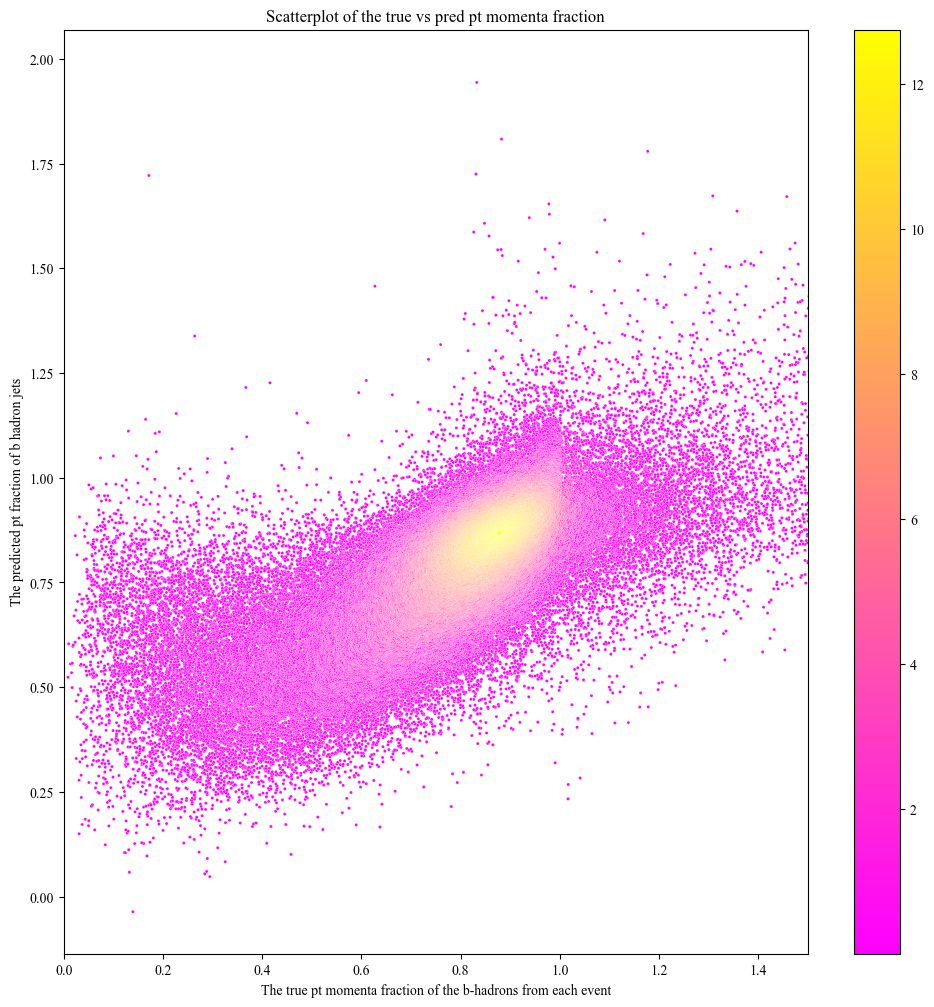

In [159]:
import matplotlib as mpl
from scipy.stats import gaussian_kde
fig, ax = plt.subplots(figsize = (12,12))
x = bhads_targets[:,7]
y = predictions_X[:,7]
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x,
    y,
    c = z,
    s = 5,
    cmap = "spring",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "spring", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_xlim([0,1.5])
ax.set_title("Scatterplot of the true vs pred pt momenta fraction")
ax.set_xlabel("The true pt momenta fraction of the b-hadrons from each event")
ax.set_ylabel("The predicted pt fraction of b hadron jets")

/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'The predicted momenta projection of b hadron jets')

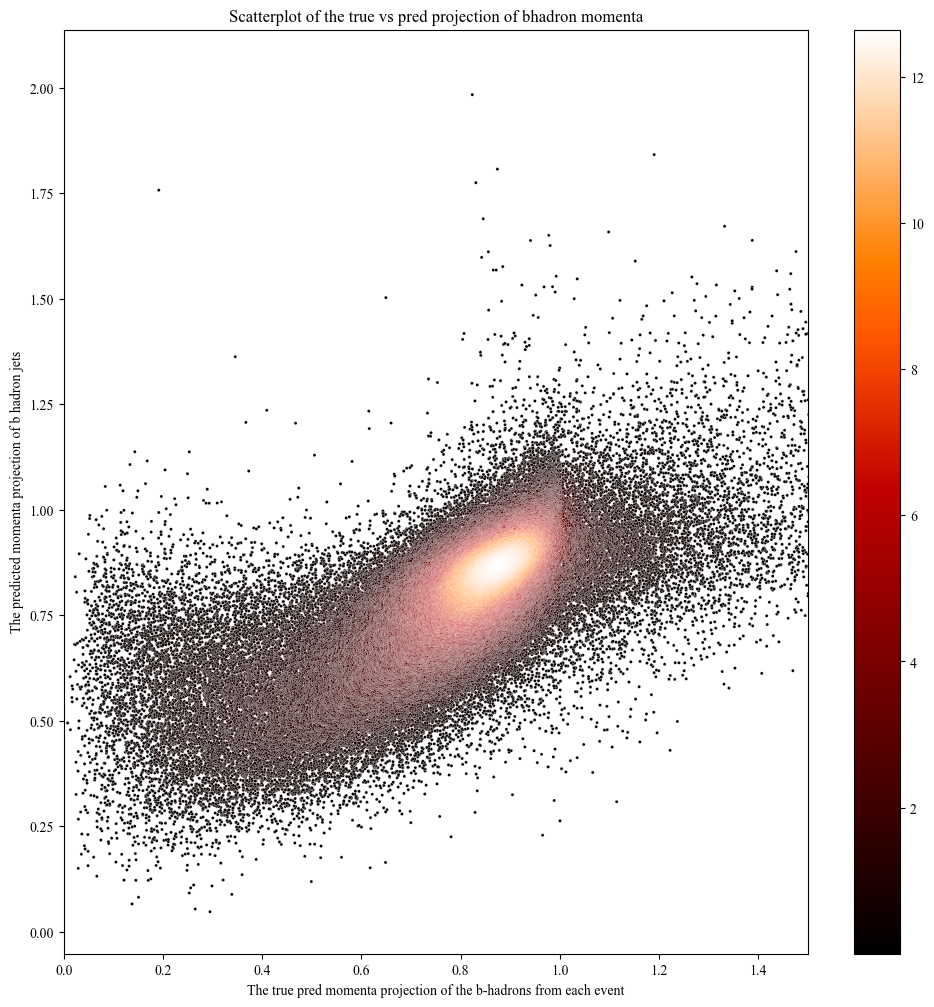

In [160]:
import matplotlib as mpl
from scipy.stats import gaussian_kde
fig, ax = plt.subplots(figsize = (12,12))
x = bhads_targets[:,8]
y = predictions_X[:,8]
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x,
    y,
    c = z,
    s = 5,
    cmap = "gist_heat",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "gist_heat", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_xlim([0,1.5])
ax.set_title("Scatterplot of the true vs pred projection of bhadron momenta")
ax.set_xlabel("The true pred momenta projection of the b-hadrons from each event")
ax.set_ylabel("The predicted momenta projection of b hadron jets")

/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'The predicted Bhadron energy of b hadron jets')

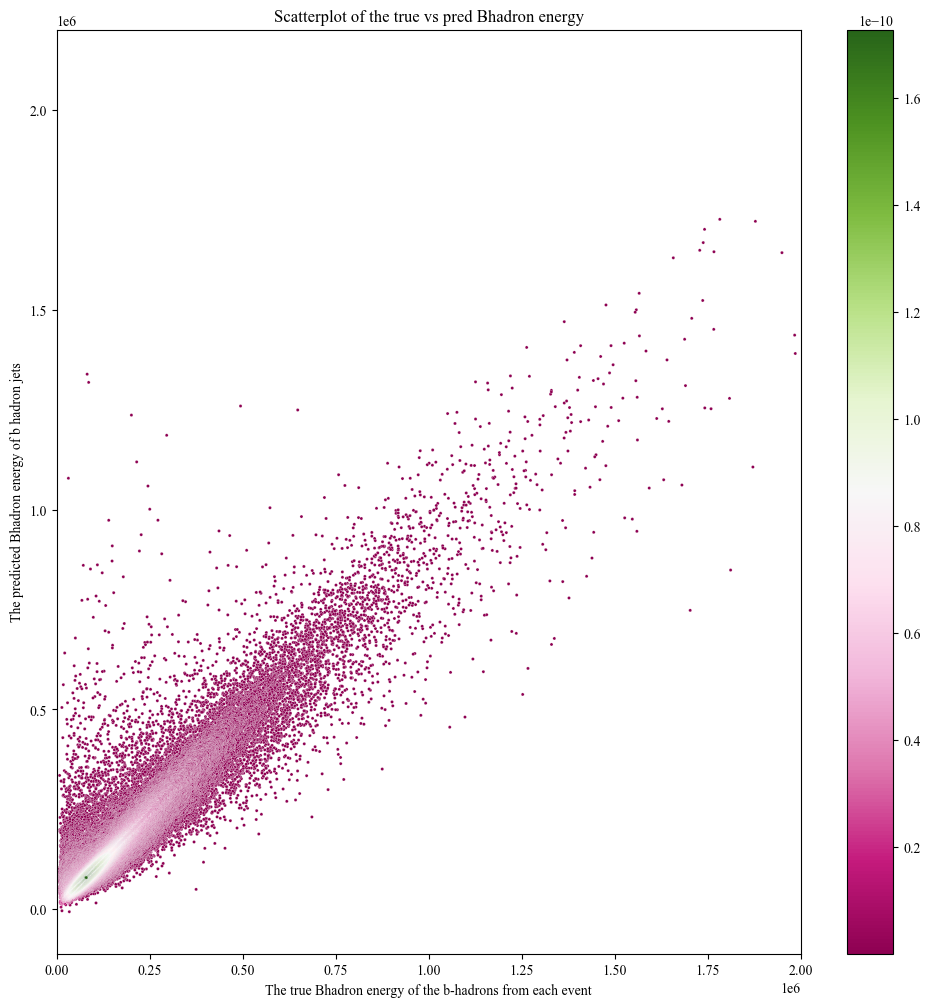

In [162]:
import matplotlib as mpl
from scipy.stats import gaussian_kde
fig, ax = plt.subplots(figsize = (12,12))
x = bhads_targets[:,6]*1e6
y = predictions_X[:,6]*1e6
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x,
    y,
    c = z,
    s = 5,
    cmap = "PiYG",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "PiYG", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_xlim([0,2e6])
ax.set_title("Scatterplot of the true vs pred Bhadron energy")
ax.set_xlabel("The true Bhadron energy of the b-hadrons from each event")
ax.set_ylabel("The predicted Bhadron energy of b hadron jets")

In [163]:
DeepSetProjector.save_weights("/home/physics/phujdj/WeightsSaved/MultivariateParticleDeepSets.ckpt")

In [165]:
# Builds the deep neural network
track_layers = [64 for x in range(2)]
jet_layers = [100 for x in range(3)]
b_jets_layers = [64 for x in range(2)]

track_layers = [np.shape(particles_input_scaled)[2]]+track_layers
print(track_layers)
print(np.shape(onehot)[1])
#Initializers the optimizer used for training the network
optimizer = tf.keras.optimizers.Nadam(LR)

#Build a DeepSets Projection Neural Network
DeepSetProjector2 = DeepSetsProjection(track_layers=track_layers, b_jet_layers= b_jets_layers, jet_layers=jet_layers, n_targets=np.shape(bhads_targets)[1], n_targets_classification= np.shape(onehot)[1], regularizer_strength= 1e-4, n_features=np.shape(b_jets_input_scaled)[1], Dropout_rate=0.1)

[15, 64, 64]
3


In [166]:
from DeepSetNeuralNetArchitecture import LogNormal_Loss_Function
from HffragDeepSetsProjection import Multivariate_Gaussian_Negative_Likelihood_Loss_Curve
from HffragDeepSetsProjectionMultivariate import weighted_categorical_crossentropy
DeepSetProjector2.compile(
 optimizer = optimizer,
 loss = {"MultivariateLoss": Multivariate_Gaussian_Negative_Likelihood_Loss_Curve, "MassOutput":tf.keras.losses.categorical_crossentropy},
 metrics = [Mean_Squared_Error]   
)

In [167]:
path = "/home/physics/phujdj/WeightsSaved/MultivariateParticleDeepSets.ckpt"
checkpoint = os.path.dirname(path)
latest_DeepNet = tf.train.latest_checkpoint(checkpoint)

In [168]:
DeepSetProjector2.load_weights(latest_DeepNet)

In [173]:
#Evaluate the entire performance of the model
loss = DeepSetProjector2.evaluate((particles_input_scaled,b_jets_input_scaled),(bhads_targets, onehot),verbose = 2)
print("The Loaded DeepNet has loss: ", loss)

3021/3021 - 13s - loss: -1.6538e+01 - MultivariateLoss_loss: -1.8286e+01 - MassOutput_loss: 1.0070 - MultivariateLoss_Mean_Squared_Error: 0.0241 - MassOutput_Mean_Squared_Error: 0.2045 - 13s/epoch - 4ms/step
The Loaded DeepNet has loss:  [-16.53771209716797, -18.285667419433594, 1.0070375204086304, 0.024120915681123734, 0.20454014837741852]


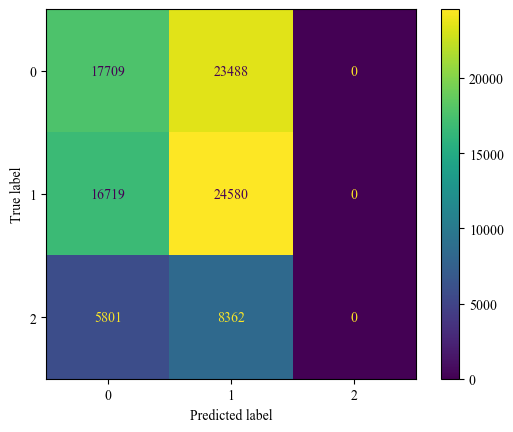

In [174]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
confusion_mat = confusion_matrix(np.argmax(onehot, axis = 1), np.argmax(Predictions_Mass,axis = 1))
confusion_visualized = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_mat)
confusion_visualized.plot()